<a href="https://colab.research.google.com/github/Ppangchon/project/blob/main/model21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model 21

In [ ]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import PIL
import plotly
import plotly.graph_objs as go
import pandas as pd
from numpy import array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Dense, Conv2D, AveragePooling2D, Flatten, Dropout, BatchNormalization, MaxPool2D)
import time
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Sequential
import requests
from IPython.display import Image
from io import BytesIO  
import pickle as p 
import plotly.graph_objs as go  
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import backend as K
K.image_data_format()
from keras.utils import np_utils

## เตรียมชุดของข้อมูล

In [ ]:
from google.colab import drive # เชื่อม drive ของเรา ถ้าเชื่อมสำเร็จจะขึ้นคำว่า Mounted at /content/drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os # os จัดการเกี่ยวกับไฟล์ต่างๆ ในโฟล์เดอร์
path = '/content/drive/My Drive/lastoct'  # data เราอยู่โฟล์เดอร์ไหน

In [ ]:
image = cv2.imread('/content/drive/My Drive/lastoct/train/CSC/IA3870 19-12-16 RE_000_cropped.png')

In [ ]:
batch_size = 32   # กำหนดขนาดของแต่ละการอ่านข้อมูล
img_height = 256  # ความสูงของรูปภาพแต่ละรูป
img_width = 256   # ความกว้างของรูปภาพแต่ละรูป

num_classes = 4

## Train

In [6]:
# Train
train_dir = "/content/drive/My Drive/lastoct/train"
train_datagen = ImageDataGenerator(rescale = 1./255,
         rotation_range = 50,
         zoom_range = 0.5)

train_set = train_datagen.flow_from_directory(train_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

Found 17779 images belonging to 4 classes.


In [7]:
print('Train')
ids, counts = np.unique(train_set.classes, return_counts=True)
print(ids)        # คลาส
print(counts)     # จำนวนภาพของคลาส

Train
[0 1 2 3]
[4552 4469 4385 4373]


In [8]:
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
labels

for i in ids:
  print('{:>6} = {}' .format(labels[i], counts[i]))

   CSC = 4552
Normal = 4469
   PCV = 4385
   VKH = 4373


In [9]:
train_set[0][0][0].shape   # W*H*3 (3 Channel RGB) 

(256, 256, 3)

## Validation

In [10]:
# Validation
val_dir ="/content/drive/My Drive/lastoct/validation"
val_datagen = ImageDataGenerator(rescale = 1./255,         
       rotation_range = 50,
       zoom_range = 0.5)

val_set = val_datagen.flow_from_directory(val_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

Found 2217 images belonging to 4 classes.


In [11]:
print('Validation')
ids, counts = np.unique(val_set.classes, return_counts=True)
print(ids)        # คลาส
print(counts)     # จำนวนข้อมูลของคลาส

Validation
[0 1 2 3]
[528 546 540 603]


## Test

In [12]:
# Test
test_dir ="/content/drive/My Drive/lastoct/test"
test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = tf.keras.utils.image_dataset_from_directory(test_dir,image_size=(img_height, img_width))

Found 2182 files belonging to 4 classes.


In [13]:
class_names = test_set.class_names
print(class_names)

['CSC', 'Normal', 'PCV', 'VKH']


##### ดูตัวอย่างคลาส และแสดงภาพ

{'CSC': 0, 'Normal': 1, 'PCV': 2, 'VKH': 3}
(32, 256, 256, 3)
(32, 4)
class: [0. 0. 1. 0.]


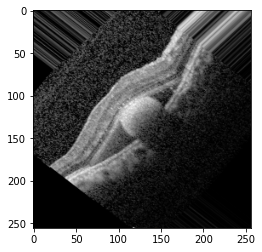

In [14]:
# เป็นการสุ่มดูภาพใน train_set
print(train_set.class_indices)
for image_batch, labels_batch in  train_set:
  print(image_batch.shape)
  print(labels_batch.shape)
  plt.imshow(image_batch[0])
  print('class:', labels_batch[0])  # ภาพอยู่ในคลาสใด
  break

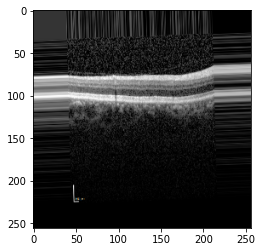

In [15]:
plt.imshow(val_set[0][0][0])
plt.show()

### Visualize ดูภาพ

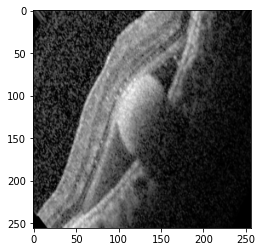

In [16]:
plt.imshow(train_set[0][0][0])
plt.show()

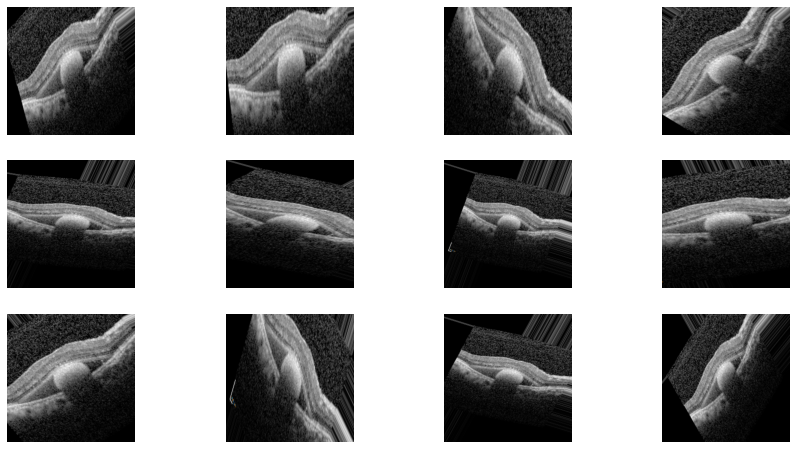

In [17]:
# ดูหลายภาพ
nplots = 12

def visual_multi(images_arr):
  fig = plt.figure(figsize = (15, 8))
  for j in range(nplots):
    plt.subplot(3, 4, j+1)
    plt.imshow(images_arr[j])
    plt.axis('off')
  plt.show()

augmented_images = [train_set[0][0][0] for i in range(nplots)]
visual_multi(augmented_images)

## Training 

### สร้าง Model

In [18]:
num_classes = 4
epochs=10   # จำนวนครั้งที่เราจะ Train
# ขนาดภาพอินพุตเข้าสู่ Model
in_shape = (256,256,3)
in_shape

(256, 256, 3)

In [19]:
model = Sequential()   # สร้าง Model

# สร้างชั้น Convolution ชั้นแรก ค่าพารามิเตอร์ activation ใช้ ReLU
model.add(Conv2D(16, (3,3), activation = 'relu', input_shape = in_shape))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))    # สร้างชั้น Max Pooling ค่าพารามิเตอร์ 2,2 คือ Pool Size

# ชั้นที่ 2
model.add(Conv2D(32, (3,3), activation = 'relu'))
model.add(MaxPool2D((2,2)))

# ชั้นที่ 3 
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D((2,2)))

# FULLY CONNECTED LAYER
model.add(Flatten())
model.add(Dense(64, activation='relu'))

# Output layer
model.add(Dense(4, activation='softmax')) # 4 คลาส
model.summary()          # ดูสรุปโครงสร้าง Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0

##### ดู kernel

In [20]:
for layer in model.layers:
  if 'conv' not in layer.name:
       continue
  kernels, biases = layer.get_weights()
  print(layer.name, 'shape:', kernels.shape)

conv2d shape: (3, 3, 3, 16)
conv2d_1 shape: (3, 3, 16, 32)
conv2d_2 shape: (3, 3, 32, 64)


In [21]:
k_min, k_max = kernels.min(), kernels.max()
kernels = (kernels - k_min)/ (k_max - k_min)
kernel_idx = 0
kernel_i = kernels[:, :, 0, kernel_idx]
print(kernel_i.round(2))

[[0.84 0.73 0.22]
 [0.89 0.88 0.79]
 [0.46 0.59 0.78]]


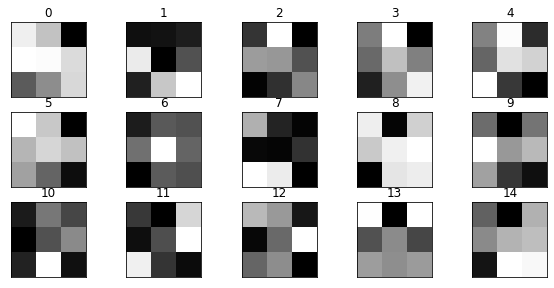

In [22]:
nplots = 15
fig = plt.figure(figsize = (10, 8))
for j in range(nplots):
  plt.subplot(5, 5, j+1)
  plt.imshow(kernels[:, :, 0, j], cmap = plt.cm.gray)
  plt.title(j)
  plt.xticks([]); plt.yticks([])
plt.show()

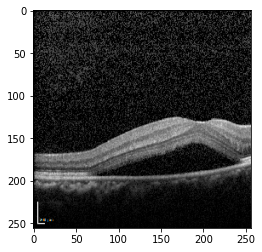

In [23]:
image = load_img('/content/drive/My Drive/lastoct/train/CSC/IA3870 19-12-16 RE_000_cropped.png', target_size=(256, 256))
plt.imshow(image)
plt.show()

In [24]:
img1 = img_to_array(image)
print('shape =', img1.shape)
print('max pixel value =', np.max(img1))

shape = (256, 256, 3)
max pixel value = 255.0


### Compile และ Train

In [25]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [26]:
start = time.time()

history = model.fit(train_set, steps_per_epoch=len(train_set), 
                    validation_data=val_set, 
                    epochs=10,verbose=1)

end = time.time()
print("Time Taken: {:.2f} minutes".format((end-start)/60))

Epoch 1/10
556/556 [==============================] - 5151s 9s/step - loss: 1.5417 - accuracy: 0.3176 - val_loss: 1.3842 - val_accuracy: 0.2738
Epoch 2/10
556/556 [==============================] - 2218s 4s/step - loss: 1.2844 - accuracy: 0.3975 - val_loss: 1.2902 - val_accuracy: 0.3965
Epoch 3/10
556/556 [==============================] - 2205s 4s/step - loss: 1.1256 - accuracy: 0.5062 - val_loss: 1.1505 - val_accuracy: 0.4696
Epoch 4/10
556/556 [==============================] - 2189s 4s/step - loss: 1.0372 - accuracy: 0.5562 - val_loss: 1.0213 - val_accuracy: 0.5507
Epoch 5/10
556/556 [==============================] - 2204s 4s/step - loss: 0.9523 - accuracy: 0.6006 - val_loss: 0.9406 - val_accuracy: 0.6062
Epoch 6/10
556/556 [==============================] - 2204s 4s/step - loss: 0.8802 - accuracy: 0.6377 - val_loss: 0.9646 - val_accuracy: 0.6112
Epoch 7/10
556/556 [==============================] - 2200s 4s/step - loss: 0.8112 - accuracy: 0.6689 - val_loss: 1.2240 - val_accuracy:

### Save Model

In [27]:
with open('history_model', 'wb') as file:
   p.dump(history.history, file)

filepath='model21.h5'
model.save(filepath)
filepath_model = 'model21.json'
filepath_weights = 'weights_model.h5'
model_json = model.to_json()
with open(filepath_model, "w") as json_file:
   json_file.write(model_json)

model.save_weights('weights_model.h5')
print("Saved model to disk")

Saved model to disk


### Load Model

In [28]:
with open('history_model', 'rb') as file:
   his = p.load(file)

h1 = go.Scatter(y=his['val_accuracy'],
mode="lines", line=dict(
width=2,
color='blue'),
name="val_accuracy"
)
h2 = go.Scatter(y=his['val_loss'],
mode="lines", line=dict(
width=2,
color='red'),
name="val_loss"
)

data = [h1,h2]
layout1 = go.Layout(title='Loss',
xaxis=dict(title='epochs'),
yaxis=dict(title=' '))
fig1 = go.Figure(data, layout=layout1)
plotly.offline.iplot(fig1, filename="testOCT")
predict_model = load_model(filepath)
predict_model.summary()
with open(filepath_model, 'r') as f:
   loaded_model_json = f.read()
predict_model = model_from_json(loaded_model_json)
predict_model.load_weights(filepath_weights)
print("Loaded model from disk")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0

## ประเมิน

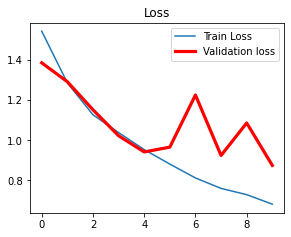

In [29]:
plt.figure(figsize = (10, 3.5))
plt.subplot(1, 2 , 1)
plt.title('Loss')
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], 'r', lw = 3.2, label = 'Validation loss')
plt.legend()

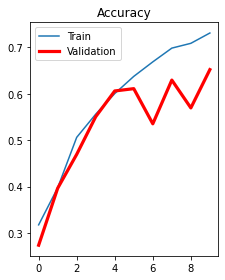

In [30]:
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label = 'Train')
plt.plot(history.history['val_accuracy'], 'r', lw = 3.2, label = 'Validation')
plt.legend()
plt.tight_layout()
plt.show()

In [31]:
acc = model.evaluate(val_set, steps = len(val_set), verbose = 0)
print('score = {:.3f}' .format(acc[1]))

score = 0.637


### Prediction

In [32]:
import requests
from IPython.display import Image
from io import BytesIO
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.preprocessing import image 
import keras.utils as image

1/1 [==============================] - 1s 538ms/step
CSC tf.Tensor(0.17487772, shape=(), dtype=float32) Normal tf.Tensor(0.47536692, shape=(), dtype=float32) PCV tf.Tensor(0.17487772, shape=(), dtype=float32) VKH tf.Tensor(0.17487772, shape=(), dtype=float32)


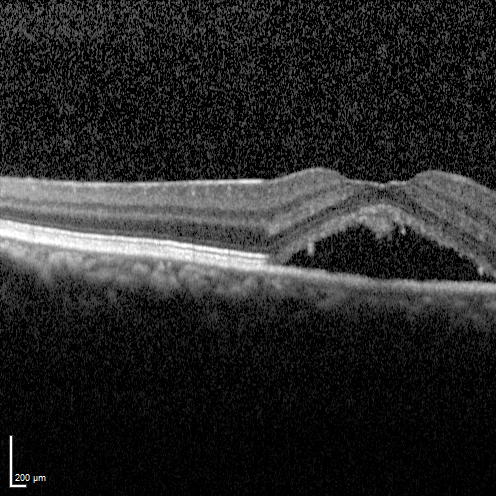

AI Normal มีความมั่นใจ 47.54%.


In [33]:
# CSC
test_path = ('/content/drive/My Drive/lastoct/test/CSC/FQ8979 23-03-12 RE_000_cropped.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"Normal",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "Normal"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

1/1 [==============================] - 0s 47ms/step
CSC tf.Tensor(0.17487772, shape=(), dtype=float32) Normal tf.Tensor(0.47536692, shape=(), dtype=float32) PCV tf.Tensor(0.17487772, shape=(), dtype=float32) VKH tf.Tensor(0.17487772, shape=(), dtype=float32)


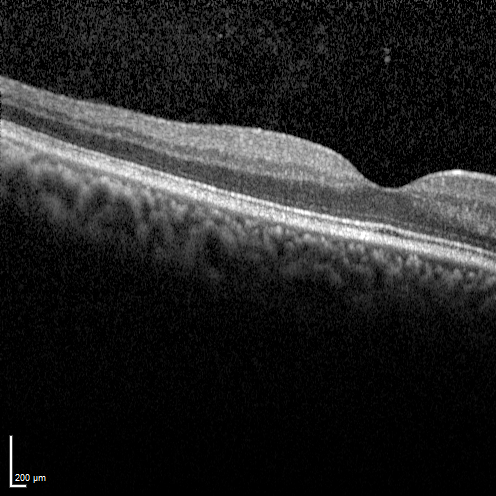

AI Normal มีความมั่นใจ 47.54%.


In [34]:
# Normal
test_path = ('/content/drive/My Drive/lastoct/test/Normal/CJ5901 24-01-19 RE_000_cropped.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"Normal",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "Normal"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

1/1 [==============================] - 0s 70ms/step
CSC tf.Tensor(0.17487772, shape=(), dtype=float32) Normal tf.Tensor(0.47536692, shape=(), dtype=float32) PCV tf.Tensor(0.17487772, shape=(), dtype=float32) VKH tf.Tensor(0.17487772, shape=(), dtype=float32)


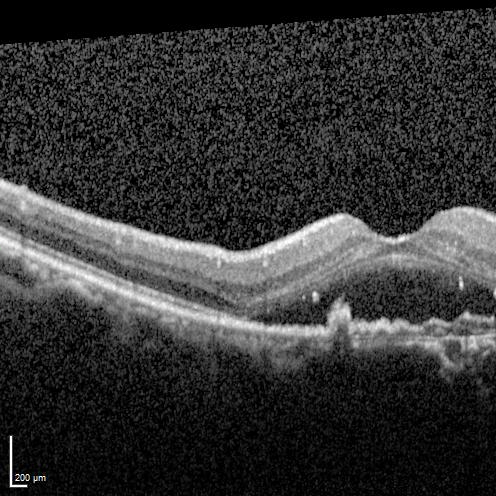

AI Normal มีความมั่นใจ 47.54%.


In [35]:
# PCV
test_path = ('/content/drive/My Drive/lastoct/test/PCV/AV0940 20-09-16 RE_001003_cropped.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"Normal",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "Normal"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

1/1 [==============================] - 0s 74ms/step
CSC tf.Tensor(0.1748777, shape=(), dtype=float32) Normal tf.Tensor(0.1748777, shape=(), dtype=float32) PCV tf.Tensor(0.1748777, shape=(), dtype=float32) VKH tf.Tensor(0.47536686, shape=(), dtype=float32)


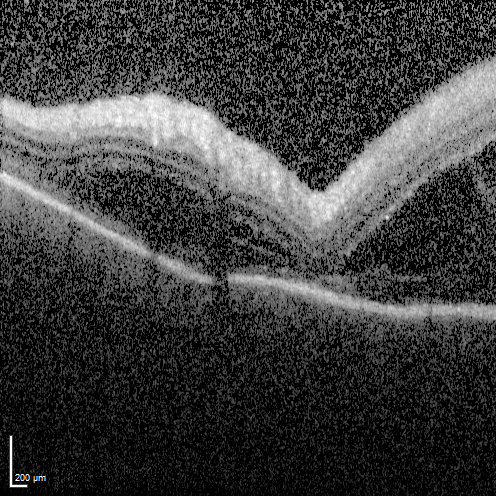

AI VKH มีความมั่นใจ 47.54%.


In [36]:
# VKH
test_path = ('/content/drive/My Drive/lastoct/test/VKH/KH7322 18-12-20 LE_001004_cropped.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"Normal",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "Normal"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

### Testing

In [37]:
y_test = []; y_pred = []
class_names = test_set.class_names
for images, labels in test_set:
  for i in range(len(list(labels))):
    img_array = keras.preprocessing.image.img_to_array(images[i])
    X_test = tf.expand_dims(img_array, 0)
    score = predict_model.predict(X_test)
    if score[0][0]==np.max(score):
      eye = "CSC"
    elif score[0][1]==np.max(score):
      eye = "Normal"
    elif score[0][2]==np.max(score):
      eye = "PCV"
    elif score[0][3]==np.max(score):
      eye = "VKH"
    y_pred.append(eye)
    y_test.append(class_names[labels[i]])

1/1 [==============================] - 0s 49ms/step


In [38]:
print(y_test)
print(len(y_test))
print(y_pred)
print(len(y_pred))

['CSC', 'Normal', 'PCV', 'VKH', 'CSC', 'CSC', 'CSC', 'PCV', 'VKH', 'VKH', 'PCV', 'CSC', 'CSC', 'VKH', 'PCV', 'Normal', 'Normal', 'Normal', 'VKH', 'VKH', 'VKH', 'CSC', 'Normal', 'VKH', 'Normal', 'Normal', 'VKH', 'Normal', 'Normal', 'Normal', 'CSC', 'PCV', 'CSC', 'PCV', 'Normal', 'Normal', 'CSC', 'VKH', 'Normal', 'PCV', 'Normal', 'Normal', 'VKH', 'Normal', 'PCV', 'CSC', 'Normal', 'VKH', 'PCV', 'VKH', 'Normal', 'VKH', 'PCV', 'CSC', 'CSC', 'PCV', 'VKH', 'Normal', 'PCV', 'CSC', 'VKH', 'Normal', 'VKH', 'CSC', 'VKH', 'Normal', 'Normal', 'PCV', 'PCV', 'PCV', 'Normal', 'CSC', 'VKH', 'PCV', 'PCV', 'VKH', 'Normal', 'VKH', 'PCV', 'CSC', 'CSC', 'CSC', 'PCV', 'PCV', 'VKH', 'VKH', 'PCV', 'VKH', 'Normal', 'Normal', 'PCV', 'Normal', 'Normal', 'Normal', 'CSC', 'CSC', 'PCV', 'CSC', 'VKH', 'CSC', 'VKH', 'PCV', 'Normal', 'VKH', 'Normal', 'Normal', 'VKH', 'CSC', 'Normal', 'PCV', 'VKH', 'PCV', 'PCV', 'Normal', 'PCV', 'PCV', 'Normal', 'VKH', 'Normal', 'VKH', 'VKH', 'Normal', 'VKH', 'VKH', 'Normal', 'CSC', 'CS

## Confusion Matrix

In [39]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
confusion_matrix(y_test, y_pred)

array([[249, 292,   2,   9],
       [ 16, 553,   0,   1],
       [149, 361,   6,  12],
       [158, 261,   0, 113]])

In [41]:
cm = confusion_matrix(y_test, y_pred)

In [42]:
test_set.class_names

['CSC', 'Normal', 'PCV', 'VKH']

In [43]:
cm_df = pd.DataFrame(cm,
                     index = ['CSC', 'Normal', 'PCV', 'VKH'], 
                     columns = ['CSC', 'Normal', 'PCV', 'VKH'])

In [44]:
cm_df

,CSC,Normal,PCV,VKH
CSC,249,292,2,9
Normal,16,553,0,1
PCV,149,361,6,12
VKH,158,261,0,113


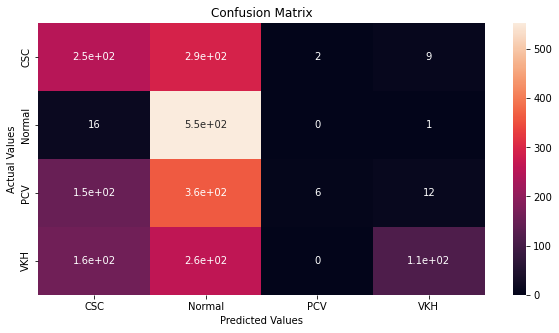

In [45]:
plt.figure(figsize=(10,5))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
     

### หาค่า Accuracy,Recall, Precision, F1-score

In [46]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [47]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)

Accuracy: 0.422090


In [48]:
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='weighted') ### ในส่วนของ average='weighted' หนูไม่มั่นใจว่าควรใส่เป็น macro, micro หรือ weight
print('Recall: %f' % recall)

Recall: 0.422090


In [49]:
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='weighted') ### ในส่วนของ average='weighted' หนูไม่มั่นใจว่าควรใส่เป็น macro, micro หรือ weight
print('Precision: %f' % precision)

Precision: 0.594163


In [50]:
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='weighted') ### ในส่วนของ average='weighted' หนูไม่มั่นใจว่าควรใส่เป็น macro, micro หรือ weight
print('F1 score: %f' % f1)

F1 score: 0.341949
